In [230]:
import wfdb
import matplotlib.pyplot as plt
from constants import *
from main import *
import h5py
import librosa as lr
import matplotlib.pyplot as plt
from librosa import display
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score


In [132]:
gpu_id = 0 # Select GPU to be used: 0-3
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_id], True)

    except RuntimeError as e:
        print(e)

In [232]:
def transform_undef(hypnogram):
    hypnogram[hypnogram == 0] = 5
    return hypnogram

def get_sleep_stages(record):
    stages,_,_ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    return transform_undef(stages[0:len(stages):30*200])

def get_signal(record):
    # 'F4-M1'
    signal = wfdb.rdrecord(TRAIN_PATH+record, channels=[1]).p_signal
    return signal.reshape((len(signal),))

def get_validation_input(record):
    X = []
    signal = get_signal(record)
        
    while signal.size != 0:
        if signal[0:30*200].size != 6000:
            pass
        else:
            # calculate melspectogram (db)
            X.append(lr.power_to_db(
                lr.feature.melspectrogram(y=signal[0:30*200], sr=200, 
                                          n_fft=1024, hop_length=256)))
            signal = signal[30*200:]
    return np.array(X)

def get_classification_input(record_list):
    X = []
    Y = np.array([])
    
    for record in record_list:
        signal = get_signal(record)
        s_stages = get_sleep_stages(record)
        
        while signal.size != 0:
            if signal[0:30*200].size != 6000:
                # remove the last element from s_stages
                s_stages = np.delete(s_stages, -1)
                pass
            else:
                # calculate melspectogram (db)
                X.append(lr.power_to_db(
                    lr.feature.melspectrogram(y=signal[0:30*200], sr=200, 
                                             n_fft=1024, hop_length=256)))
            signal = signal[30*200:]
            
        Y = np.append(Y, s_stages)
    return np.array(X), Y

def plot_contigency_table(hypnogram, random_hypnogram, name):
    labels = ["N3","N2","N1","REM","WAKE","TOTAL"]
    
    # Check if a stage hasn't reached
    for i in range(1,5):
        if i not in hypnogram:
            labels.pop(i-1)
            
    fig, ax = plt.subplots(figsize=(6, 4))
    
    conf_mat = confusion_matrix(hypnogram, random_hypnogram)
    cont_table = contingency_table(conf_mat)
    
    sns.heatmap(cont_table, cmap='YlOrRd', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels,
                mask=get_mask(cont_table))
    sns.heatmap(cont_table, cmap='binary', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels, ax = ax,
                cbar=False, mask=~get_mask(cont_table))
    
    ax.set_ylabel("real value")
    ax.set_xlabel("random value")
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    plt.title(name)
    plt.show()
    
def contingency_table(conf_mat):
    total = np.sum(conf_mat)
    total_rand = np.sum(conf_mat, axis=0)
    
    total_real = np.sum(conf_mat, axis=1)
    total_real = np.append(total_real, total)
    
    conf_mat = np.vstack((conf_mat, total_rand))
    
    return np.concatenate((conf_mat, total_real[:, None]), axis=1)


def get_mask(cont_table):
    # Default all sleep stages were reached 
    # len(cont_table) = 6
    my_mask = np.array([[False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [True,True,True,True,True,True]])
    if len(cont_table) == 5:
        my_mask = np.array([
            [False, False, False, False, True],
            [False, False, False, False, True],
            [False, False, False, False, True],
            [False, False, False, False, True],
            [True, True, True, True, True]])
        
    if len(cont_table) == 4:
        my_mask = np.array([
            [False, False, False, True],
            [False, False, False, True],
            [False, False, False, True],
            [True, True, True, True]])
        
    return my_mask


In [134]:
record_list = get_all_records(TRAIN_PATH, "RECORDS")
rec = record_list[:200]

## Preprocessing

In [135]:
# Create input data

X, Y = get_classification_input(rec)
print(X.shape, "\t", Y.shape)
Y

(184492, 128, 24) 	 (184492,)


array([5., 5., 5., ..., 2., 2., 2.])

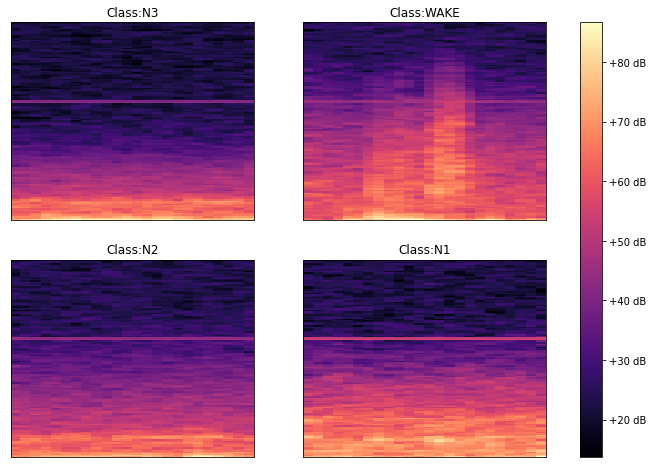

In [136]:
# Visualize the data

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
ax0, ax1, ax2, ax3 = axes.flatten()

img=lr.display.specshow(X[101], ax=ax0, sr=200)
ax0.set_title("Class:{}".format(TICK_LABELS.get(Y[101])))

lr.display.specshow(X[2], ax=ax1, sr=200)
ax1.set_title("Class:{}".format(TICK_LABELS.get(Y[2])))

lr.display.specshow(X[80], ax=ax2, sr=200)
ax2.set_title("Class:{}".format(TICK_LABELS.get(Y[80])))

lr.display.specshow(X[20], ax=ax3, sr=200)
ax3.set_title("Class:{}".format(TICK_LABELS.get(Y[20])))

fig.colorbar(img, ax=axes, format="%+2.f dB")

In [137]:
# One Hot Encoding
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train = tf.expand_dims(X_train, axis=-1)
X_val = tf.expand_dims(X_val, axis=-1)

print("training:", X_train.shape, Y_train.shape)
print("validation:", X_val.shape, Y_val.shape)

training: (147593, 128, 24, 1) (147593, 5)
validation: (36899, 128, 24, 1) (36899, 5)


## Model

In [154]:
class Model:
    def __init__(self):
        self.model = tf.keras.Sequential([
            layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same",
                         input_shape=(128, 24, 1)),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Conv2D(filters=8, kernel_size=(2, 2), activation="relu",padding="same"),
            layers.MaxPool2D(pool_size=(2, 2), padding="same"),
            layers.Conv2D(filters=4, kernel_size=(2, 2), activation="relu",padding="same"),
            layers.Flatten(),
            layers.Dense(100, input_shape=(192,), activation="relu"),
            layers.Dense(80, activation="relu"),
            layers.Dense(60, activation="relu"),
            layers.Dense(5, activation="softmax")
        ])
    def get_model(self):
        return self.model

In [155]:
model = Model()
model = model.get_model()

In [156]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

## Training

In [157]:
hist = model.fit(
    X_train,
    Y_train,
    batch_size=16,
    shuffle=True,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=[callback]
)
model.save("model2")

Epoch 1/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.9433 - accuracy: 0.6171 - val_loss: 0.8120 - val_accuracy: 0.6664
Epoch 2/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7987 - accuracy: 0.6765 - val_loss: 0.7813 - val_accuracy: 0.6818
Epoch 3/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7683 - accuracy: 0.6910 - val_loss: 0.7574 - val_accuracy: 0.6961
Epoch 4/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7489 - accuracy: 0.6991 - val_loss: 0.7651 - val_accuracy: 0.6977
Epoch 5/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7377 - accuracy: 0.7035 - val_loss: 0.7585 - val_accuracy: 0.6956
Epoch 6/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7293 - accuracy: 0.7074 - val_loss: 0.7367 - val_accuracy: 0.7059
Epoch 7/100
9225/9225 [==============================] - 40s 4ms/step - loss: 0.7211 - accuracy: 0.7102 - val_loss: 0.7197 -

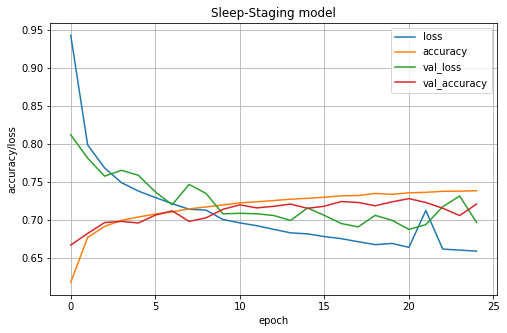

In [252]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Sleep-Staging model")
plt.xlabel("epoch")
plt.ylabel("accuracy/loss")
plt.show()

## Validate the model on unseen data

In [253]:
unseen_rec = record_list[301:303]

X_unseen, Y_unseen = get_classification_input(unseen_rec)
X_unseen = tf.expand_dims(X_unseen, axis=-1)

print(X_unseen.shape, "\t", Y_unseen.shape)

(1781, 128, 24, 1) 	 (1781,)


In [254]:
Y_predict = model.predict_classes(X_unseen)
Y_predict+=1
"""for record in unseen_rec:
    X_unseen = get_validation_input(record)
    validation.append(model.predict_classes(tf.expand_dims(X_unseen, axis=-1)))"""

'for record in unseen_rec:\n    X_unseen = get_validation_input(record)\n    validation.append(model.predict_classes(tf.expand_dims(X_unseen, axis=-1)))'

In [255]:
acc = accuracy_score(Y_unseen, Y_predict)
kappa = np.abs(cohen_kappa_score(Y_unseen, Y_predict))

print(acc, kappa)

0.7501403705783268 0.6351160909501499


In [257]:
cm = confusion_matrix(Y_unseen, Y_predict)

Text(0.5, 1.0, 'accuracy = 0.75, $\\kappa$ = 0.64')

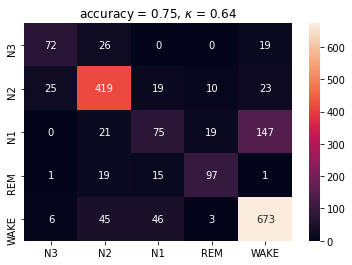

In [258]:
labels = ["N3","N2","N1","REM","WAKE"]
title = "accuracy = {:.2f}, $\kappa$ = {:.2f}".format(acc, kappa)

sns.heatmap(cm, fmt="d", annot=True, yticklabels=labels, xticklabels=labels)
plt.title(title)